## ML - Powerlifting (Group 2)
- Ankushev Vladislav
- Makarov Sergei 
- Shvartser Grigory 

#### Brief – Dataset Description

- Public-domain archive of powerlifting history
- Powerlifting is a sport in which competitors compete to lift the most weight for their class in three separate barbell lifts: the Squat, Bench, and Deadlift

#### Libraries

In [356]:
import pandas as pd 
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from patsy import dmatrices

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 

scaler = StandardScaler()


#### Download data

In [305]:
power_lifting_ver2 = pd.read_csv('openpowerlifting-2024-01-06-4c732975.csv', parse_dates=['Date'])

/var/folders/c2/4b_bg8451bs9x08g0ctxcwfr0000gn/T/ipykernel_87179/3323105694.py:1: DtypeWarning:

Columns (31,33,35,38) have mixed types. Specify dtype option on import or set low_memory=False.



#### Preprocessing

We aim to create consistent dataset for ML model
- **Country: USA** – different countries have different level of powerlifting culture. It is hard to add weights for each country, in order to differentiate them
- **Federation: USAPL** – every federation claim their own bodyweight class, age class and etc. We need to provide equal conditions for sample.
- **Division: MR-O & FR-O** – every division have their own rules, which can influence on results. We need to provide equal conditions for sample
- **Equipment: Raw** – it's difficult to calculate weights for different equipments, since they may help candidates to lift. Therefore, we picked 'Raw' group
- **Delete candidates with 4th attempt** – it is unfair to give some candidates opportunity for the 4th attempt (4th attempt happens when there's a mistake in contest or the candidate wanted to make a record)
- **Save only last record** – there's a systematic error, if we leave candidates, who participated many times

**Process description:**
- We picked 5 features to predict Best3DeadliftKg
- Data had a lot of categorical data (difficult to turn into numeric ones)
- Data also is highly multicorrelated: we have 3 attempts for each discipline (Best3 means = sum of first 3 attempts)
- We picked: Sex, Age, Bodyweight, Best3SquatKg, Best3BenchKg 
- We did not pick 3 attempts for each discipline, since it's hard to calculate relevant penalty of unsuccessful attempts. This attempts have negative values. Therefore, data will be biased 

In [306]:
# USA & USAPL
usa_sample = power_lifting_ver2.query('Country == "USA" & Federation == "USAPL" & Event == "SBD" & (Division == "MR-O" | Division == "FR-O") & Equipment == "Raw"')

# Needed columns 
pre_final_sample = usa_sample[['Name', 'Sex', 'Age', 'BodyweightKg', 'Squat4Kg', 'Best3SquatKg', 'Bench4Kg', 'Best3BenchKg', 'Deadlift4Kg', 'Best3DeadliftKg', 'Date']]

# Delete 4th attempts
cleaned_final_sample = pre_final_sample.query('not ( Bench4Kg.notna() | Squat4Kg.notna() | Deadlift4Kg.notna() )')

# Drop NA & redundant columns
cleaned_final_sample = cleaned_final_sample.drop(columns=['Bench4Kg', 'Squat4Kg', 'Deadlift4Kg']).dropna().drop_duplicates()

# Calculate – candidate frequency
candidate_freq = cleaned_final_sample.Name.value_counts().reset_index().rename(columns = {'count': 'candidate_freq'})

# merge data
cleaned_final_sample = cleaned_final_sample.merge(candidate_freq, on = 'Name', how = 'left')

# Subset –> two or more frequency
subset_two_more = cleaned_final_sample.query('candidate_freq >= 2')

# Pick last record
last_date = subset_two_more.groupby('Name').agg({'Date':'max'}).reset_index().rename(columns = {'Date': 'last_date'})

# Merge data
subset_two_more = subset_two_more.merge(last_date, on = 'Name', how = 'left')

# Query last dates
subset_two_more_last_date = subset_two_more.query('Date == last_date')

# Candidates with 1 frequency
one_freq_data = cleaned_final_sample.query('candidate_freq < 2')

# Delete bad users 
bad_users = subset_two_more_last_date.Name.value_counts().reset_index().query('count >= 2').Name.to_list()
subset_two_more_last_date = subset_two_more_last_date.query('Name not in @bad_users')

# Concat datasets
full_data = pd.concat([one_freq_data, subset_two_more_last_date])

# Delete redundant columns 
full_data = full_data.drop(columns=['Name','Date', 'candidate_freq', 'last_date'])

# Delete mix gender
full_data = full_data.query('Sex != "Mx"')

# Delete negative Best3
full_data = full_data.query('not (Best3SquatKg < 0 | Best3BenchKg < 0 | Best3DeadliftKg < 0)')

full_data

,Sex,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg
1,F,26.5,57.00,102.5,60.0,115.0
5,F,29.5,63.00,85.0,50.0,95.0
13,F,43.5,114.65,92.5,82.5,140.0
18,M,32.5,82.45,167.5,125.0,220.0
24,M,26.5,92.90,195.0,130.0,227.5
...,...,...,...,...,...,...
56829,M,39.0,89.80,165.0,115.0,187.5
56840,M,38.0,97.15,207.5,152.5,207.5
56847,M,25.0,100.00,227.5,152.5,262.5
56867,F,26.0,88.00,132.5,65.0,150.0


#### Transformations

- One-hot encoding for Sex variable


In [307]:
# Transform Sex to is_man 
full_data['is_man'] = full_data['Sex'].apply(lambda x: 1 if x == 'M' else 0)

# Drop Sex column
full_data = full_data.drop(columns=['Sex'])

#### VIF Analysis (1)
- Demonstration –> data is highly multicollineared

In [400]:
subset = full_data.drop(columns='Best3DeadliftKg')

vif_data = pd.DataFrame()
vif_data["feature"] = subset.columns
vif_data["VIF"] = [variance_inflation_factor(subset.values, i) for i in range(len(subset.columns))]

print(vif_data)

        feature        VIF
0           Age   9.098078
1  BodyweightKg  24.718214
2  Best3SquatKg  55.625390
3  Best3BenchKg  60.871807
4        is_man   7.521391


#### Interpretation – VIF Analysis (1):
- VIF values are high
- One way to decrease it: combine variables

#### VIF Analysis – correction (2)
- Get rid of multicollinearity by combining variables:
    - Bodyweight for 1 year = BodyweightKg / Age
    - Average of Best 3 Squat and Bench attempts = (Squat + Bench) / 2 

In [309]:
# Body_weight_1_year metric
subset['Body_weight_1_year'] = round(subset['BodyweightKg'] / subset['Age'], 2)

# avg_Squat_Bench metric
subset['avg_Squat_Bench'] = round((subset['Best3SquatKg'] + subset['Best3BenchKg']) / 2, 2)

# drop columns
subset_new = subset.drop(columns=['Age', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg'])

# VIF
vif_data = pd.DataFrame()
vif_data["feature"] = subset_new.columns
vif_data["VIF"] = [variance_inflation_factor(subset_new.values, i) for i in range(len(subset_new.columns))]

print(vif_data)


              feature        VIF
0              is_man   5.680063
1  Body_weight_1_year   9.588939
2     avg_Squat_Bench  16.165531


#### Interpretation – VIF correction (3)
- VIF values are high, which can lead to multicollinearity
- Delete Body_weight_1_year, since it's not suitable metric to interpret

In [310]:
# Drop columns
subset_new = subset.drop(columns=['Age', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Body_weight_1_year'])

# Vif
vif_data = pd.DataFrame()
vif_data["feature"] = subset_new.columns
vif_data["VIF"] = [variance_inflation_factor(subset_new.values, i) for i in range(len(subset_new.columns))]

print(vif_data)

           feature       VIF
0           is_man  5.545326
1  avg_Squat_Bench  5.545326


#### Interpretation – VIF correction (3)

- VIF has significantly decreased, but some researchers say that >= 5 is high

#### Correlation matrix

In [313]:
corr_data = full_data.copy()

# avg_Squat_Bench metric
corr_data['avg_Squat_Bench'] = round((corr_data['Best3SquatKg'] + corr_data['Best3BenchKg']) / 2, 2)

# Delete redundant columns
corr_data = corr_data.drop(columns = ['Age', 'BodyweightKg', 'Best3BenchKg', 'Best3SquatKg'])

# Visualize correlation
fig = px.imshow(corr_data.corr().round(2), 
                text_auto=True, 
                aspect="auto", 
                color_continuous_scale="RdBu_r", 
                title="Correlation matrix")

fig.show()

#### Interpretation – Correlation matrix:
- Still the correlation between predictors are high, which can lead to multicollinearity

##### Distribution of interactions

- check linear / non-linear interactions

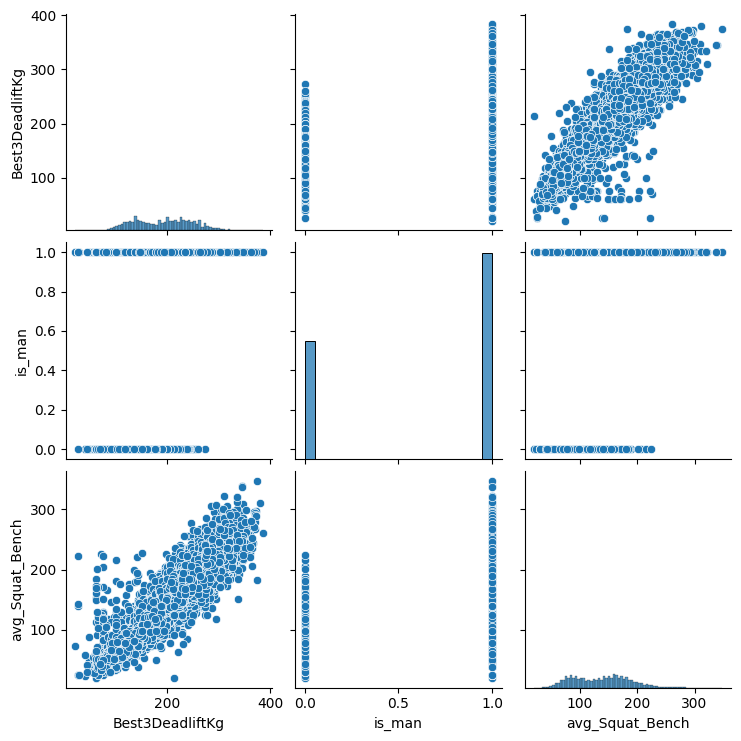

In [312]:
sns.pairplot(corr_data)

#### Interpretation – Distribution of interactions:
- The interaction between variables are linear
- No need to use regularized models 

#### OLS regression

- OLS regression is invariant to different scale of variables (it does not require to normalize data)

In [395]:
dependent_var = 'Best3DeadliftKg'
independent_vars = corr_data.columns.drop(dependent_var)

# Formula for regression: include interactions
formula = f"{dependent_var} ~ ({' + '.join(independent_vars)})**2"
print("Formula:", formula)

# Paste the formula using patsy
y, X = dmatrices(formula, data=corr_data, return_type='dataframe')

# Linear model
model = sm.OLS(y, X).fit()
print(model.summary())

Formula: Best3DeadliftKg ~ (is_man + avg_Squat_Bench)**2
                            OLS Regression Results                            
Dep. Variable:        Best3DeadliftKg   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 1.051e+05
Date:                Sun, 30 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:09:17   Log-Likelihood:            -1.7852e+05
No. Observations:               40794   AIC:                         3.570e+05
Df Residuals:                   40790   BIC:                         3.571e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

#### Interpretation – OLS regression:
- Intercept: women with 0 Squat_Bench will lift 37 kg of BestDeadlift (by best 3)
- Man differ from woman by 20 kg in Deadlift
- If avg_Squat_Bench for woman will increase by 1kg, their BestDeadlift increase by 1 kg
- If avg_Squat_Bench for man will increase by 1kg, their BestDeadlift decrease by 0.08 kg

#### OLS Metrics – MAE, RMSE, R^2, Adj. R^2

In [401]:
# Split data
train_data, test_data = train_test_split(corr_data, test_size=0.2, random_state=42)
y_train, X_train = dmatrices(formula, data=train_data, return_type='dataframe')

# Create model & train
model = LinearRegression()
model.fit(X_train, y_train)

# Predict test data
y_test, X_test = dmatrices(formula, data=test_data, return_type='dataframe')
y_pred = model.predict(X_test)

# Metric calculation
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]  
p = X_test.shape[1] - 1  
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"MAE: {round(mae, 2)}")
print(f"RMSE: {round(rmse, 2)}")
print(f"R^2: {round(r2, 2)}")
print(f"Adjusted R^2: {round(adjusted_r2, 2)}")

MAE: 14.1
RMSE: 18.58
R^2: 0.89
Adjusted R^2: 0.89


/opt/anaconda3/envs/work/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



#### Interpretation – OLS Metrics
- MAE & RMSE are high
- The difference between predicted and actual values = 14 kg (MAE)
- R^2 is high 
- Signs of underfitting

#### OLS model - Visualization

In [403]:
results_df = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})

fig = px.scatter(
    results_df, x='Actual', y='Predicted', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue',
    title = 'Actual VS Predicted values – <b>OLS model</b>')
fig.show()

#### Cross-validation
- check for overfitting

##### K_fold = 3

In [320]:
# Define metrics
scoring = {'mae': 'neg_mean_absolute_error',
           'rmse': 'neg_root_mean_squared_error',
           'r2': 'r2'}

# Define number of folds
folds = KFold(n_splits=3, shuffle=True, random_state=100)
cv_results = cross_validate(model, X_train, y_train, scoring=scoring, cv=folds)

# Get rid off negative values
mae_scores_3 = -cv_results['test_mae']
rmse_scores_3 = -cv_results['test_rmse']
r2_scores_3 = cv_results['test_r2']

print("Cross-validated MAE scores:", mae_scores_3)
print("Cross-validated RMSE scores:", rmse_scores_3)
print("Cross-validated R^2 scores:", r2_scores_3)

Cross-validated MAE scores: [14.83095136 14.53120086 14.35443123]
Cross-validated RMSE scores: [20.04791152 19.22279364 18.94234783]
Cross-validated R^2 scores: [0.8764514  0.88546784 0.88847063]


##### K_fold = 5

In [321]:
# Define number of folds
folds = KFold(n_splits=5, shuffle=True, random_state=100)
cv_results = cross_validate(model, X_train, y_train, scoring=scoring, cv=folds)

# Get rid off negative values
mae_scores_5 = -cv_results['test_mae']
rmse_scores_5 = -cv_results['test_rmse']
r2_scores_5 = cv_results['test_r2']

print("Cross-validated MAE scores:", mae_scores_5)
print("Cross-validated RMSE scores:", rmse_scores_5)
print("Cross-validated R^2 scores:", r2_scores_5)

Cross-validated MAE scores: [14.98113863 14.58565902 14.6006276  14.17616521 14.51558682]
Cross-validated RMSE scores: [20.27953211 19.65924538 19.20708216 18.50976201 19.35438173]
Cross-validated R^2 scores: [0.87473451 0.87890643 0.88670734 0.89267977 0.88429352]


##### K_fold = 10

In [322]:
# Define number of folds
folds = KFold(n_splits=10, shuffle=True, random_state=100)
cv_results = cross_validate(model, X_train, y_train, scoring=scoring, cv=folds)

# Get rid off negative values
mae_scores_10 = -cv_results['test_mae']
rmse_scores_10 = -cv_results['test_rmse']
r2_scores_10 = cv_results['test_r2']

print("Cross-validated MAE scores:", mae_scores_10)
print("Cross-validated RMSE scores:", rmse_scores_10)
print("Cross-validated R^2 scores:", r2_scores_10)

Cross-validated MAE scores: [14.78368149 15.17939079 14.530435   14.63817662 14.71536352 14.48628771
 14.22097348 14.13298901 14.73793221 14.2938944 ]
Cross-validated RMSE scores: [19.76134072 20.78807807 19.43314701 19.87787047 19.44887947 18.96649361
 18.71216226 18.30263182 19.63377967 19.06944807]
Cross-validated R^2 scores: [0.88211944 0.86726692 0.8825179  0.87510005 0.88591422 0.88766012
 0.89031497 0.89491673 0.88358339 0.88506464]


#### Overfitting-check
- calculate difference between average of k-fold metrics VS metrics on the whole sample

In [408]:
# Calculate means, K-fold = 3
k_fold_metrics_3_mae = mae_scores_3.mean()
k_fold_metrics_3_rmse = rmse_scores_3.mean()
k_fold_metrics_3_r2 = r2_scores_3.mean()

# Calculate means, K-fold = 5
k_fold_metrics_5_mae = mae_scores_5.mean()
k_fold_metrics_5_rmse = rmse_scores_5.mean()
k_fold_metrics_5_r2 = r2_scores_5.mean()

# Calculate means, K-fold = 10
k_fold_metrics_10_mae = mae_scores_10.mean()
k_fold_metrics_10_rmse = rmse_scores_10.mean()
k_fold_metrics_10_r2 = r2_scores_10.mean()

print('K = 3')
print('Diff: MAE train & MAE CV =', round(mae - k_fold_metrics_3_mae, 2))
print('Diff: RMSE train & RMSE CV =', round(rmse - k_fold_metrics_3_rmse,2))
print('Diff: R2 train & R2 CV =', round(r2 - k_fold_metrics_3_r2,2))
print()
print('K = 5')
print('Diff: MAE train & MAE CV =', round(mae - k_fold_metrics_5_mae, 2))
print('Diff: RMSE train & RMSE CV =', round(rmse - k_fold_metrics_5_rmse,2 ))
print('Diff: R2 train & R2 CV =', round(r2 - k_fold_metrics_5_r2, 2))
print()
print('K = 10')
print('Diff: MAE train & MAE CV =', round(mae - k_fold_metrics_10_mae, 2))
print('Diff: RMSE train & RMSE CV =', round(rmse - k_fold_metrics_10_rmse, 2))
print('Diff: R2 train & R2 CV =', round(r2 - k_fold_metrics_10_r2, 2))

K = 3
Diff: MAE train & MAE CV = -0.48
Diff: RMSE train & RMSE CV = -0.83
Diff: R2 train & R2 CV = 0.01

K = 5
Diff: MAE train & MAE CV = -0.48
Diff: RMSE train & RMSE CV = -0.83
Diff: R2 train & R2 CV = 0.01

K = 10
Diff: MAE train & MAE CV = -0.48
Diff: RMSE train & RMSE CV = -0.82
Diff: R2 train & R2 CV = 0.01


#### Interpretation – Overfitting-check:
- No overfitting, since difference is low
- MAI & MSE are high, despite high R^2
- Hypothesis: model is underfitting (MAE = 14 kg is high, every kg matters in powerlifting, Reference results for MAE = 1-3 kg)


#### Solution:
- We don't have enough predictors to make our model more complex. 
- Therefore, we will use PCA to reduce multicollinearity

#### PCA
- to reduce multicollinearity in model

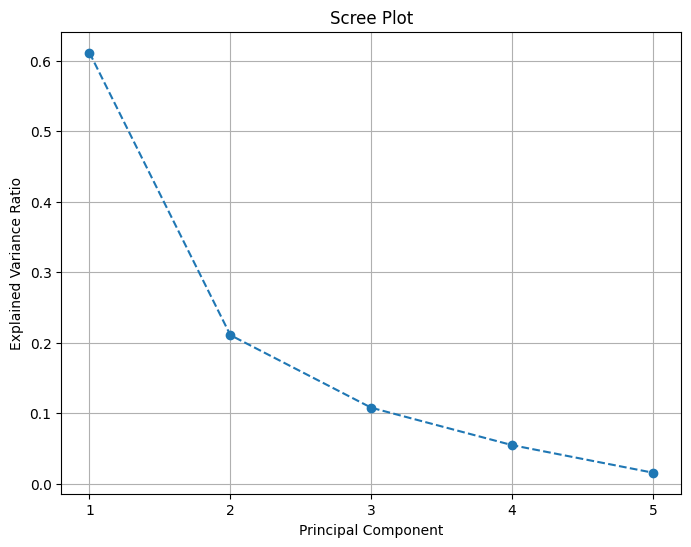

In [360]:
# Define predictors & targer
X = full_data[['is_man', 'Age', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg']]
y = full_data[['Best3DeadliftKg']]

# PCA build
pca = PCA()
X_pca = pca.fit_transform(scale(X))

# Scree plot
explained_variance_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

#### Interpretation - Scree plot
- We will pick 3 principal components

#### PCA components matrix

In [361]:
# Build model
pca = PCA(n_components=3)
X_pca = pca.fit_transform(scale(X))

# Extract components
components = pca.components_

# Extract column names
feature_names = X.columns

# Create frame
components_df = pd.DataFrame(components, columns=feature_names)
components_df

Доли объясненной дисперсии: [0.61161286 0.21073228 0.10768718]
Загрузки компонент (веса переменных):


,is_man,Age,BodyweightKg,Best3SquatKg,Best3BenchKg
0,0.489278,-0.057651,0.414067,0.535414,0.546958
1,-0.111999,0.940087,0.318002,-0.050096,0.007575
2,-0.465119,-0.327841,0.801639,-0.050251,-0.176166


#### Interpretation – PCA components matrix
Three potential groups:
- First group – genger + results of best 3 by Squat & Bench
- Second group – age
- Second group – Bodyweight

#### PCA-OLS model results

In [412]:
# Split data
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Add intercept
X_pca_train_const = sm.add_constant(X_pca_train)
X_pca_test_const = sm.add_constant(X_pca_test)

# Create OLS model 
ols_model = sm.OLS(y_train, X_pca_train_const)
ols_results = ols_model.fit()
print(ols_results.summary())

# Predict on test data
y_pred_ols = ols_results.predict(X_pca_test_const)

# Calculate metrics
mae_ols = mean_absolute_error(y_test, y_pred_ols)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
r2_ols = r2_score(y_test, y_pred_ols)

print()
print(f"OLS Model - MAE: {mae_ols}")
print(f"OLS Model - RMSE: {rmse_ols}")
print(f"OLS Model - R^2: {r2_ols}")

                            OLS Regression Results                            
Dep. Variable:        Best3DeadliftKg   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                 5.994e+04
Date:                Mon, 01 Jul 2024   Prob (F-statistic):               0.00
Time:                        01:48:19   Log-Likelihood:            -1.4760e+05
No. Observations:               32635   AIC:                         2.952e+05
Df Residuals:                   32631   BIC:                         2.952e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        192.7493      0.123   1562.692      0.0

#### Interpretation – PCA-OLS model results:
- Perfomance of PCA-OLS worse than regular OLS model
- Therefore, first model should be picked
- In future, it is suggested to use more predictors, in order to make models more complex (e.g. add level of testosterone, height, etc –> current dataset do not contain such information; recommended to combine different data sources)